In [1]:
import sys
sys.path.append('../src')

from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.rules_4 import get_log_prob
from pickle_wrapper import unpickle
import pandas as pd
import yaml
import tqdm
from numpy import log

In [2]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [3]:
num_obs=params["num_observations"]
true_norm=params['true_norm']['exp']

In [4]:
num_obs

50

In [5]:
base_path="../data_nc/exp_nc4/"
exp_paths=!ls $base_path

In [6]:
def get_num_viols(nc_obs):
    n_viols=0
    for obs in nc_obs:
        for action_pairs in zip(obs, obs[1:]):
            if action_pairs[0] in [(('pickup', 8), ('putdown', 8, '1')),(('pickup', 40), ('putdown', 40, '1'))]:
                if action_pairs[1][1][2] =='1': #not in obl zone
                    n_viols+=1
                elif action_pairs[1][1][2] =='3':
                    if action_pairs[1][1][1] not in [35,13]: #permission not applicable
                        n_viols+=1
    return (n_viols)

In [37]:
z1=pd.DataFrame()
for exp_path in exp_paths:
    temp=pd.DataFrame()
    #Add params
    obs_path=base_path+exp_path+"/obs.pickle"
    obs = unpickle(obs_path)
    temp["w_nc"] = [float(exp_path.split("w_nc=")[1].split(",")[0])]
    trial=1 if "trial" not in exp_path else exp_path.split(",trial=")[-1]
    temp["trial"]=[int(trial)]
    #Add violations
    n_viols=get_num_viols(obs)
    temp["violation_rate"]=[n_viols/num_obs]
    #Add lik,post
    prior_true=!grep "For True Norm" {base_path+exp_path+"/run.log"}
    lik_true=!grep "lik_no_norm" {base_path+exp_path+"/run.log"}
    post_true=float(prior_true[0].split("log_prior=")[-1]) + float(lik_true[0].split("lik_true_norm=")[1])
    temp["true_norm_posterior"]=[post_true]
    #Add if True Norm found in some chain
    if_true_norm=!grep "True norm in some chain(s)" {base_path+exp_path+"/chain_info.txt"}
    temp["if_true_norm_found"]= ["False" not in if_true_norm[0]]
    #Rank of True Norm if found as per posterior
    rank_df=pd.read_csv(base_path+exp_path+"/ranked_posteriors.csv",index_col=False)
    rank_true=rank_df.loc[rank_df.expression==str(to_tuple(true_norm))][["post_rank","log_posterior"]].values
    rank=rank_true[0][0] if rank_true.shape[0]==1 else None
    temp["true_norm_rank_wrt_posterior"]= [rank]
    #max posterior found in chains
    rank_1=rank_df.loc[rank_df.post_rank==1]
    temp["max_posterior_in_chain"]= [rank_1.log_posterior.values[0]]
    temp["norm_wi_max_post"]= [rank_1.expression.values[0]]
    #chain summary
    chain_details = pd.read_csv(f"{base_path+exp_path}/chain_posteriors_nc.csv")
    n_chains1=chain_details.loc[chain_details.expression==str(true_norm)].chain_number.nunique()
    temp["#chains_wi_true_norm"]= [n_chains1]
    chain_max_min=chain_details.groupby(["chain_number"])[["log_posterior"]].agg(['min', 'max', 'mean', 'std'])
    n_chains2=(chain_max_min["log_posterior","max"]>post_true).sum()
    temp["#chains_wi_post_gt_true_norm"]= [n_chains2]
    #Posterior Estimation
    n=params["n"]
    top_norms=chain_details.loc[chain_details.chain_pos>2*n\
                           ].groupby(["expression"]).agg({"log_posterior":["mean","count"]})
    top_norms["chain_rank"]=top_norms[[('log_posterior', 'count')]].rank(method='dense',ascending=False)
    top_norms.sort_values(by=["chain_rank"],inplace=True)
    rank_true_wi_freq=top_norms.iloc[top_norms.index==str(true_norm)]["chain_rank"].values
    rank_true_wi_freq = float(rank_true_wi_freq[0]) if rank_true_wi_freq.size>0 else None
    temp["#rank_true_wi_freq"]= [rank_true_wi_freq]
    post_norm_top=top_norms.loc[top_norms.chain_rank==1]["log_posterior","mean"].values
    post_norm_top = post_norm_top[0] if post_norm_top.size>0 else None
    temp["posterior_norm_top"]= [post_norm_top]
    #Num equivalent norms in posterior
    log_lik=float(lik_true[0].split("lik_true_norm=")[1])
    top_norms["log_prior"]=top_norms.index.to_series().apply(lambda x: get_log_prob("NORMS",eval(x)))[0]
    top_norms["log_lik"]=top_norms[('log_posterior',  'mean')]-top_norms["log_prior"]
    mask_equiv=abs((top_norms["log_lik"]-log_lik)/log_lik)<=0.0001
    n_equiv=mask_equiv.sum()
    temp["total_equiv_norms_in_top_norms"]= [n_equiv]
    n_equiv_20=mask_equiv[:20].sum()
    temp["total_equiv_norms_in_top_20_norms"]= [n_equiv_20]
    best_equiv_norm_rank=top_norms.loc[mask_equiv]["chain_rank"].min()
    temp["best_equiv_norm_rank"]= [best_equiv_norm_rank]
    best_equiv_norm=eval(top_norms.loc[mask_equiv].index[0]) if n_equiv>0 else None
    temp["best_equiv_norm"]= [best_equiv_norm]
    z1=z1.append(temp)

In [8]:
z1.columns

Index(['w_nc', 'trial', 'violation_rate', 'true_norm_posterior',
       'if_true_norm_found', 'true_norm_rank_wrt_posterior',
       'max_posterior_in_chain', 'norm_wi_max_post', '#chains_wi_true_norm',
       '#chains_wi_post_gt_true_norm', '#rank_true_wi_freq',
       'posterior_norm_top', 'total_equiv_norms_in_top_norms',
       'total_equiv_norms_in_top_20_norms', 'best_equiv_norm_rank',
       'best_equiv_norm'],
      dtype='object')

In [38]:
z1["if_equiv_norm_found"]=z1["total_equiv_norms_in_top_norms"]>0

z1["if_true_or_equiv_norm_found"]=z1["if_equiv_norm_found"] | z1["if_true_norm_found"]

z1["true_post/max_post"]=z1["true_norm_posterior"]/z1["max_posterior_in_chain"]
z1["%chains_wi_true_norm"]=z1["#chains_wi_true_norm"]/10
z1["%chains_wi_post_gt_true_norm"]=z1["#chains_wi_post_gt_true_norm"]/10

z1["expected_violation_rate"]=z1["w_nc"]*108/243

In [10]:
z1["chk"]=z1["violation_rate"]/z1["expected_violation_rate"]

### Summary

In [34]:
print ("%trials where true norms found: {:.2%}".format(z1["if_true_norm_found"].mean()))
print ("%trials where equiv norms found: {:.2%}".format(z1["if_equiv_norm_found"].mean()))
print ("%trials where true/equiv norms found: {:.2%}".format(z1["if_true_or_equiv_norm_found"].mean()))

%trials where true norms found: 72.22%
%trials where equiv norms found: 8.33%
%trials where true/equiv norms found: 75.00%


### Where are neither True nor equivalent Norms found ?

In [26]:
z1.groupby(["w_nc"]).agg({"if_true_or_equiv_norm_found":"mean","trial":"count",\
                                    "true_norm_posterior":"mean"})

,if_true_or_equiv_norm_found,trial,true_norm_posterior
w_nc,,,
0.00,1.000000,3,-270.471604
0.05,1.000000,3,-270.191375
0.10,1.000000,3,-270.658586
0.15,0.666667,3,-280.299258
0.20,0.666667,3,-281.046158
0.25,0.666667,3,-281.007207
0.30,1.000000,3,-281.325899
0.35,0.333333,3,-283.469682
0.40,0.333333,3,-284.264247


array([<AxesSubplot:xlabel='w_nc'>, <AxesSubplot:xlabel='w_nc'>,
       <AxesSubplot:xlabel='w_nc'>, <AxesSubplot:xlabel='w_nc'>],
      dtype=object)

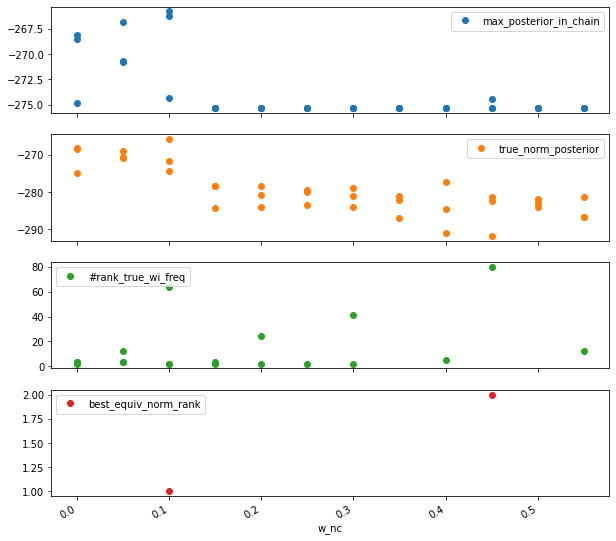

In [24]:
import matplotlib.pyplot as plt
z1.plot(x="w_nc",y=["max_posterior_in_chain","true_norm_posterior",\
                   "#rank_true_wi_freq","best_equiv_norm_rank"],subplots=True,\
        marker="o",kind = 'line',ls="none",figsize = (10,10))
#z1.plot(x="chk",y="true_norm_posterior",kind="scatter")

In [14]:
108/243*0.3

0.13333333333333333

In [15]:
z1.groupby(["w_nc","violation_rate"]).agg({"trial":"count","if_true_or_equiv_norm_found":"mean"})

trial  if_true_or_equiv_norm_found
w_nc violation_rate                                    
0.00 0.00                3                         True
0.05 0.00                3                         True
0.10 0.00                2                         True
     0.02                1                         True
0.15 0.02                1                         True
     0.04                1                         True
     0.10                1                        False
0.20 0.02                1                         True
     0.04                1                        False
     0.06                1                         True
0.25 0.04                1                         True
     0.08                1                         True
     0.10                1                        False
0.30 0.04                1                         True
     0.10                1                         True
     0.14                1                         True
0.35 0.06                1                         True
     0.08                1                        False
     0.14                1                        False
0.40 0.00                1                         True
     0.12                1                        False
     0.22                1                        False
0.45 0.04                1                         True
     0.08                1                        False
     0.22                1                         True
0.50 0.08                1                         True
     0.12                1                         True
     0.18                1                         True
0.55 0.10                1                         True
     0.12                1                         True
     0.18                1                        False

In [45]:
z1["true_norm_rank_wrt_posterior"]=pd.to_numeric(z1["true_norm_rank_wrt_posterior"])
z1["#rank_true_wi_freq"]=pd.to_numeric(z1["#rank_true_wi_freq"])

In [52]:
res1=z1.groupby(["w_nc"]).agg({"trial":["count"],"true_norm_rank_wrt_posterior":"mean",\
                        "#rank_true_wi_freq":"mean","best_equiv_norm_rank":"mean"})
res1

,trial,true_norm_rank_wrt_posterior,#rank_true_wi_freq,best_equiv_norm_rank
,count,mean,mean,mean
w_nc,,,,
0.00,3,1.000000,2.666667,NaN
0.05,3,2.000000,6.000000,NaN
0.10,3,4.000000,22.666667,1.0
0.15,3,2.500000,2.500000,NaN
0.20,3,3.000000,13.000000,NaN
0.25,3,2.000000,2.000000,NaN
0.30,3,17.000000,21.500000,NaN
0.35,3,19.000000,NaN,NaN


In [54]:
res1[[("true_norm_rank_wrt_posterior","mean"),\
      ("#rank_true_wi_freq","mean"),("best_equiv_norm_rank","mean")]].min(axis=1)

w_nc
0.00     1.000000
0.05     2.000000
0.10     1.000000
0.15     2.500000
0.20     3.000000
0.25     2.000000
0.30    17.000000
0.35    19.000000
0.40     3.000000
0.45     2.000000
0.50    26.333333
0.55    12.000000
dtype: float64

In [35]:
z1.groupby(["w_nc"]).agg({"trial":"count","if_true_norm_found":[("mean")],"if_equiv_norm_found":"mean",\
                          "if_true_or_equiv_norm_found":"mean","true_norm_posterior":"mean",\
                          "true_post/max_post":"mean","%chains_wi_true_norm":"mean"})

,trial,if_true_norm_found,if_equiv_norm_found,if_true_or_equiv_norm_found,true_norm_posterior,true_post/max_post,%chains_wi_true_norm
,count,mean,mean,mean,mean,mean,mean
w_nc,,,,,,,
0.00,3,1.000000,0.000000,1.000000,-270.471604,1.000000,0.500000
0.05,3,1.000000,0.000000,1.000000,-270.191375,1.002835,0.500000
0.10,3,1.000000,0.666667,1.000000,-270.658586,1.006949,0.433333
0.15,3,0.666667,0.000000,0.666667,-280.299258,1.017988,0.200000
0.20,3,0.666667,0.000000,0.666667,-281.046158,1.020701,0.166667
0.25,3,0.666667,0.000000,0.666667,-281.007207,1.020560,0.133333
0.30,3,1.000000,0.000000,1.000000,-281.325899,1.021717,0.266667
0.35,3,0.333333,0.000000,0.333333,-283.469682,1.029503,0.033333


In [17]:
z1.dtypes

w_nc                                 float64
trial                                  int64
violation_rate                       float64
true_norm_posterior                  float64
if_true_norm_found                      bool
true_norm_rank_wrt_posterior          object
max_posterior_in_chain               float64
norm_wi_max_post                      object
#chains_wi_true_norm                   int64
#chains_wi_post_gt_true_norm           int64
#rank_true_wi_freq                    object
posterior_norm_top                   float64
total_equiv_norms_in_top_norms         int64
total_equiv_norms_in_top_20_norms      int64
best_equiv_norm_rank                 float64
best_equiv_norm                       object
if_equiv_norm_found                     bool
if_true_or_equiv_norm_found             bool
true_post/max_post                   float64
%chains_wi_true_norm                 float64
%chains_wi_post_gt_true_norm         float64
expected_violation_rate              float64
chk       

In [55]:
z1

,w_nc,trial,violation_rate,true_norm_posterior,if_true_norm_found,true_norm_rank_wrt_posterior,max_posterior_in_chain,norm_wi_max_post,#chains_wi_true_norm,#chains_wi_post_gt_true_norm,...,total_equiv_norms_in_top_norms,total_equiv_norms_in_top_20_norms,best_equiv_norm_rank,best_equiv_norm,if_equiv_norm_found,if_true_or_equiv_norm_found,true_post/max_post,%chains_wi_true_norm,%chains_wi_post_gt_true_norm,expected_violation_rate
0,0.00,1,0.00,-268.505429,True,1.0,-268.505429,"('Norms', ('Obl', ('Moved', ('Colour', 'any'),...",4,0,...,0,0,NaN,None,False,True,1.000000,0.4,0.0,0.000000
0,0.00,2,0.00,-268.099963,True,1.0,-268.099963,"('Norms', ('Obl', ('Moved', ('Colour', 'any'),...",6,0,...,0,0,NaN,None,False,True,1.000000,0.6,0.0,0.000000
0,0.00,3,0.00,-274.809420,True,1.0,-274.809420,"('Norms', ('Obl', ('Moved', ('Colour', 'any'),...",5,0,...,0,0,NaN,None,False,True,1.000000,0.5,0.0,0.000000
0,0.05,1,0.00,-270.752600,True,1.0,-270.752600,"('Norms', ('Obl', ('Moved', ('Colour', 'any'),...",6,0,...,0,0,NaN,None,False,True,1.000000,0.6,0.0,0.022222
0,0.05,2,0.00,-270.719470,True,2.0,-270.701002,"('Norms', ('Obl', ('Moved', ('Colour', 'r'), (...",6,6,...,0,0,NaN,None,False,True,1.000068,0.6,0.6,0.022222
0,0.05,3,0.00,-269.102056,True,3.0,-266.850504,"('Norm', ('Obl', ('Moved', ('Colour', 'any'), ...",3,7,...,0,0,NaN,None,False,True,1.008438,0.3,0.7,0.022222
0,0.10,1,0.02,-271.809412,True,10.0,-266.258560,"('Norm', ('Obl', ('Moved', ('Colour', 'r'), ('...",4,10,...,0,0,NaN,None,False,True,1.020848,0.4,1.0,0.044444
0,0.10,2,0.00,-274.355860,True,1.0,-274.355860,"('Norms', ('Obl', ('Moved', ('Colour', 'r'), (...",4,0,...,0,0,NaN,None,False,True,1.000000,0.4,0.0,0.044444
0,0.10,3,0.00,-265.810487,True,1.0,-265.810487,"('Norms', ('Obl', ('Moved', ('Colour', 'r'), (...",5,5,...,2,2,1.0,"[Norms, [Obl, [Moved, ['Colour', 'any'], ['Sha...",True,True,1.000000,0.5,0.5,0.044444
0,0.15,1,0.10,-284.226394,False,NaN,-275.346219,"('No-norm', 'true')",0,10,...,0,0,NaN,None,False,False,1.032251,0.0,1.0,0.066667


In [19]:
true_norm

['Norms',
 ['Obl',
  ['Moved',
   ['Colour', 'r'],
   ['Shape', 'any'],
   ['Zone', '1'],
   ['Next-Move', ['Colour', 'any'], ['Shape', 'any']]],
  ['Zone', '2']],
 ['Per',
  ['Action', 'putdown'],
  ['Colour', 'any'],
  ['Shape', 'square'],
  ['PerZone', '3']]]

In [36]:
z1.loc[~(z1.if_true_norm_found)][["w_nc","best_equiv_norm_rank","best_equiv_norm"]].values

array([[0.15, nan, None],
       [0.2, nan, None],
       [0.25, nan, None],
       [0.35, nan, None],
       [0.35, nan, None],
       [0.4, nan, None],
       [0.4, nan, None],
       [0.45, nan, None],
       [0.45, 2.0,
        list(['Norm', ['Pro', ['Action', 'putdown'], ['Colour', 'g'], ['Shape', 'any'], ['Zone', '3']]])],
       [0.55, nan, None]], dtype=object)